In [42]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso

## Load the excel file into a dataframe 

In [43]:
df = pd.read_csv("Sales_no_outliers.csv")
df.head()

,Unnamed: 0,Year,Company Name,Country,GICS Sub-Industry,Industry (Exiobase),Environmental Intensity (Sales),Total Environmental Cost,SDG 1.5,SDG 2.1,...,SDG 12.2,SDG 14.1,SDG 14.2,SDG 14.3,SDG 14.c,SDG 15.1,SDG 15.2,SDG 15.5,% Imputed,Revenue
0,0,2019,SAGA PLC,UNITED KINGDOM OF GREAT BRITAIN AND NORTHERN I...,Multi-line Insurance,Activities auxiliary to financial intermediati...,-2.887178,-3.184231e+07,-1.394280e+07,-8.142779e+06,...,-1059.042606,-4.739468,-1.027193,-3584.970569,-5.649112,70.667599,70.667599,-1297.277948,0.006135,1.102887e+09
1,1,2019,BURSA MALAYSIA BHD,MALAYSIA,Financial Exchanges & Data,Activities auxiliary to financial intermediati...,-1.677157,-1.968379e+06,-8.526458e+05,-5.027080e+05,...,-168.146428,-1.410813,-1.207108,-222.196310,-1.681590,10.138780,10.138780,-79.398691,0.043215,1.173640e+08
2,2,2019,INTERTEK GROUP PLC,UNITED KINGDOM OF GREAT BRITAIN AND NORTHERN I...,Research & Consulting Services,Activities auxiliary to financial intermediati...,-1.529690,-6.059927e+07,-2.653317e+07,-1.555781e+07,...,-3804.051175,-17.024036,-3.689647,-6861.392776,-20.291452,253.836024,253.836024,-2470.054721,0.011467,3.961539e+09
3,3,2019,JSE LIMITED,SOUTH AFRICA,Financial Exchanges & Data,Activities auxiliary to financial intermediati...,-1.462497,-2.290124e+06,-9.958814e+05,-5.768109e+05,...,-901.413470,-0.189720,-1.009642,-253.366805,-0.226133,-3.169102,-3.169102,-92.619013,0.016390,1.565900e+08
4,4,2019,BUREAU VERITAS SA,FRANCE,Research & Consulting Services,Activities auxiliary to financial intermediati...,-0.699273,-3.997865e+07,-1.751484e+07,-1.043041e+07,...,-4116.308632,-37.818819,-9.136488,-4606.916825,-45.077368,586.030400,586.030400,-1632.997165,0.033005,5.717172e+09


## runFixedEffects()
Function to run the Categorical Fixed Effects and return the r squared value and the summary of the regression

In [44]:
def runFixedEffects(X, y, df_selected, list_effectNames):
    """_summary_
    Runs the Categorical Fixed Effects and return the r squared value and the summary of the regression
    
    Args:
        X (dataframe): Independent variables for the model
        y (dataframe): Dependent variables for the model
        df_selected (dataframe): Main source dataframe
        list_effectNames (list<string>): List of effects we want to fix.

    Returns:
        float: contain the adjusted r squared value 
        summary: contains the full summary of the model
    """
    
    list_df_Effects = list()

    # Create as list of the dummy variables for the fixed effects 
    for columnName in list_effectNames:
        df_temp = pd.get_dummies(df_selected[columnName], drop_first=True)
        df_temp = df_temp.astype(int)
        list_df_Effects.append(df_temp)
    
    # Add the dummies to the independent variables
    X = pd.concat(list_df_Effects, axis=1)
    # Add a constant (intercept) to the independent variables
    X = sm.add_constant(X)
    
    # Fit the OLS model
    model = sm.OLS(y, X).fit() 
    
    # Calculate  and return the adjusted R-squared
    adjusted_r_squared = 1 - (1 - model.rsquared) * (len(y) - 1) / (len(y) - X.shape[1] - 1)
    
    return adjusted_r_squared, model.summary()

## Constant & Often used variables 
Setup which dependent and independent variables to use

In [45]:
independentVariables = ["SDG 1.5", "SDG 2.1", "SDG 2.2", "SDG 2.3", "SDG 2.4", "SDG 3.3", 
                         "SDG 3.4", "SDG 3.9", "SDG 6", "SDG 12.2", "SDG 14.1", "SDG 14.2", 
                         "SDG 14.3", "SDG 14.c", "SDG 15.1", "SDG 15.2", "SDG 15.5"]

y_sales = df["Environmental Intensity (Sales)"]
X = df[independentVariables]

d_RSquaredAll = {}
l_RsquaredForEffect = []

## Fixed Effect: Year
#### Dependent Variable: Sales

In [46]:
list_effectNames = ['Year']
adjusted_r_squared, year_summary = runFixedEffects(X,y_sales,df, list_effectNames)
print(f'Adjusted R-squared (Fixed on Year): {adjusted_r_squared:.6f}')
print(year_summary)

d_RSquaredAll['Year'] = adjusted_r_squared

Adjusted R-squared (Fixed on Year): 0.001001
                                   OLS Regression Results                                  
Dep. Variable:     Environmental Intensity (Sales)   R-squared:                       0.002
Model:                                         OLS   Adj. R-squared:                  0.001
Method:                              Least Squares   F-statistic:                     2.655
Date:                             Sun, 08 Oct 2023   Prob (F-statistic):            0.00449
Time:                                     13:23:41   Log-Likelihood:                -63313.
No. Observations:                            13872   AIC:                         1.266e+05
Df Residuals:                                13862   BIC:                         1.267e+05
Df Model:                                        9                                         
Covariance Type:                         nonrobust                                         
                 coef    std err   

## Fixed Effect: Country
#### Dependent Variable: Sales

In [47]:
list_effectNames = ['Country']
adjusted_r_squared, country_summary = runFixedEffects(X,y_sales,df, list_effectNames)
print(f'Adjusted R-squared (Fixed on Year): {adjusted_r_squared:.6f}')
print(country_summary)

d_RSquaredAll['Country'] = adjusted_r_squared

Adjusted R-squared (Fixed on Year): 0.061488
                                   OLS Regression Results                                  
Dep. Variable:     Environmental Intensity (Sales)   R-squared:                       0.066
Model:                                         OLS   Adj. R-squared:                  0.062
Method:                              Least Squares   F-statistic:                     14.58
Date:                             Sun, 08 Oct 2023   Prob (F-statistic):          2.28e-155
Time:                                     13:23:41   Log-Likelihood:                -62851.
No. Observations:                            13872   AIC:                         1.258e+05
Df Residuals:                                13804   BIC:                         1.264e+05
Df Model:                                       67                                         
Covariance Type:                         nonrobust                                         
                                   

## Fixed Effect: Year and GICS Sub-Industry
#### Dependent Variable: Sales

In [48]:
list_effectNames = ['Year', 'GICS Sub-Industry']
adjusted_r_squared, yearGICS_summary = runFixedEffects(X,y_sales,df, list_effectNames)
print(f'Adjusted R-squared (Fixed on Year and GICS Sub-Industry): {adjusted_r_squared:.4f}')
print(yearGICS_summary)

d_RSquaredAll['Year + GICS Sub-Industry'] = adjusted_r_squared

Adjusted R-squared (Fixed on Year and GICS Sub-Industry): 0.5036
                                   OLS Regression Results                                  
Dep. Variable:     Environmental Intensity (Sales)   R-squared:                       0.509
Model:                                         OLS   Adj. R-squared:                  0.504
Method:                              Least Squares   F-statistic:                     88.98
Date:                             Sun, 08 Oct 2023   Prob (F-statistic):               0.00
Time:                                     13:23:42   Log-Likelihood:                -58386.
No. Observations:                            13872   AIC:                         1.171e+05
Df Residuals:                                13711   BIC:                         1.183e+05
Df Model:                                      160                                         
Covariance Type:                         nonrobust                                         
               

## Fixed Effect: Year and Industry (Exiobase)
#### Dependent Variable: Sales

In [49]:
list_effectNames = ['Year', 'Industry (Exiobase)']
adjusted_r_squared, yearIndustry_summary = runFixedEffects(X,y_sales,df, list_effectNames)
print(f'Adjusted R-squared (Fixed on Year and Industry (Exiobase)): {adjusted_r_squared:.4f}')
print(yearIndustry_summary)

d_RSquaredAll['Year + Industry (Exiobase)'] = adjusted_r_squared

Adjusted R-squared (Fixed on Year and Industry (Exiobase)): 0.4479
                                   OLS Regression Results                                  
Dep. Variable:     Environmental Intensity (Sales)   R-squared:                       0.451
Model:                                         OLS   Adj. R-squared:                  0.448
Method:                              Least Squares   F-statistic:                     176.9
Date:                             Sun, 08 Oct 2023   Prob (F-statistic):               0.00
Time:                                     13:23:42   Log-Likelihood:                -59172.
No. Observations:                            13872   AIC:                         1.185e+05
Df Residuals:                                13807   BIC:                         1.190e+05
Df Model:                                       64                                         
Covariance Type:                         nonrobust                                         
             

## Fixed Effect: Year, GICS Sub-Industry, and Country
#### Dependent Variable: Sales

In [50]:
list_effectNames = ['Year', 'GICS Sub-Industry', 'Country']
adjusted_r_squared, yearGICSCountry_summary = runFixedEffects(X,y_sales,df, list_effectNames)
print(f'Adjusted R-squared (Fixed on Year, GICS Sub-Industry and Country): {adjusted_r_squared:.4f}')
print(yearGICSCountry_summary)

d_RSquaredAll['Year + GICS Sub-Industry + Country'] = adjusted_r_squared

Adjusted R-squared (Fixed on Year, GICS Sub-Industry and Country): 0.5389
                                   OLS Regression Results                                  
Dep. Variable:     Environmental Intensity (Sales)   R-squared:                       0.547
Model:                                         OLS   Adj. R-squared:                  0.539
Method:                              Least Squares   F-statistic:                     72.44
Date:                             Sun, 08 Oct 2023   Prob (F-statistic):               0.00
Time:                                     13:23:42   Log-Likelihood:                -57840.
No. Observations:                            13872   AIC:                         1.161e+05
Df Residuals:                                13644   BIC:                         1.179e+05
Df Model:                                      227                                         
Covariance Type:                         nonrobust                                         
      

## Bar Graph
Display in a bar graph the r-squared values for the different fixed effects

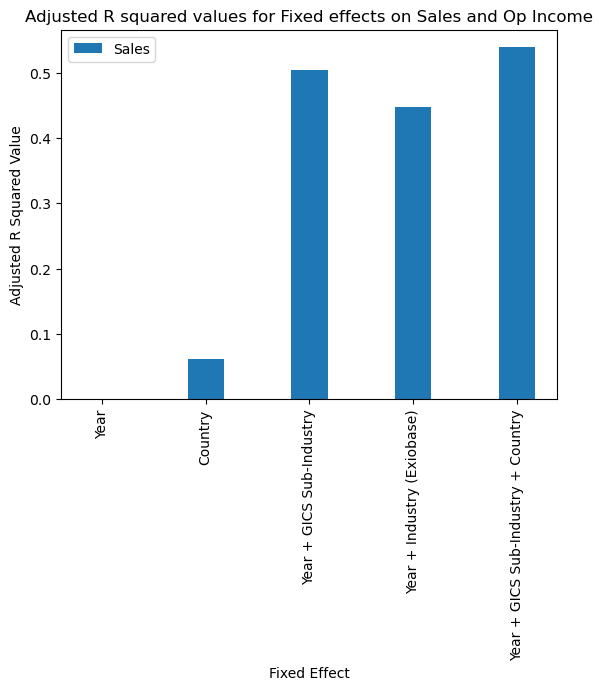

In [58]:
# Extract category names and values
categories = list(d_RSquaredAll.keys())
onSales = [value for value in d_RSquaredAll.values()]

# Set the width of the bars
bar_width = 0.35

# Create the X-axis values for the bar groups
x = range(len(categories))

# Create the bar plots for fixed effect on sale and on operating income
plt.bar(x, onSales, width=bar_width, label='Sales')

# Label the X-axis with category names
plt.xlabel('Fixed Effect')
plt.xticks([i for i in x], categories, rotation=90)

# Label the Y-axis
plt.ylabel('Adjusted R Squared Value')

# Add a legend
plt.legend()

# Set the title
plt.title('Adjusted R squared values for Sales with Fixed effects')

# Show the plot
plt.show()

## Same effects but only the brewers

In [ ]:
df_GICSBrewFiltered = df[df['GICS Sub-Industry'] == 'Brewers']
df_GICSBrewFiltered.head()

,Unnamed: 0,Year,Company Name,Country,GICS Sub-Industry,Industry (Exiobase),Environmental Intensity (Sales),Environmental Intensity (Op Inc),Revenue,Operating Income,...,SDG 6,SDG 12.2,SDG 14.1,SDG 14.2,SDG 14.3,SDG 14.c,SDG 15.1,SDG 15.2,SDG 15.5,% Imputed
481,514,2019,CHINA RESOURCES BEER (HLDGS),HONG KONG,Brewers,Manufacture of beverages,-15.946035,-230.947142,4.837699e+09,3.340250e+08,...,-4.916364e+08,-16055.630122,-208.514000,-20.615434,-32400.406335,-248.534000,2942.501775,2942.501775,-11471.686931,0.000931
483,516,2019,BUDWEISER BREWING CO,CAYMAN ISLANDS,Brewers,Manufacture of beverages,-7.019612,-37.638941,6.582921e+09,1.227706e+09,...,-2.484940e+08,-21847.771988,-140.450129,-28.052546,-25278.227923,-167.406661,1886.414782,1886.414782,-8773.429720,0.017490
484,517,2019,MOLSON COORS BEVERAGE CO,UNITED STATES OF AMERICA,Brewers,Manufacture of beverages,-6.596233,-46.522794,1.057940e+10,1.500000e+09,...,-3.977745e+08,-77571.792798,-1113.208360,-326.988191,-37024.568588,-1326.865949,15176.840942,15176.840942,-12261.768244,0.059202
486,519,2019,COMPANIA CERVECERIAS UNIDAS,CHILE,Brewers,Manufacture of beverages,-6.415653,-54.146661,2.423979e+09,2.872090e+08,...,-9.485571e+07,-65916.007408,-104.142317,-467.109898,-5751.475432,-124.130306,-1430.679992,-55213.362037,-2224.738635,0.084882
490,523,2019,ANHEUSER-BUSCH INBEV,BELGIUM,Brewers,Manufacture of beverages,-3.388736,-11.492977,5.248464e+10,1.547524e+10,...,-1.909141e+08,-222519.248882,-3914.291085,-325.789140,-190769.424529,-4665.559245,56659.806086,56659.806086,-64862.799133,0.080199


In [ ]:
y_brew_sales = df_GICSBrewFiltered["Environmental Intensity (Sales)"]
X_brew = df_GICSBrewFiltered[independentVariables]

In [ ]:
list_effectNames = ['Year']
adjusted_r_squared, year_summary = runFixedEffects(X_brew,y_brew_sales,df_GICSBrewFiltered, list_effectNames)
print(f'Adjusted R-squared (Fixed on Year): {adjusted_r_squared:.6f}')
print(year_summary)

Adjusted R-squared (Fixed on Year): -0.015092
                                   OLS Regression Results                                  
Dep. Variable:     Environmental Intensity (Sales)   R-squared:                       0.091
Model:                                         OLS   Adj. R-squared:                 -0.003
Method:                              Least Squares   F-statistic:                    0.9636
Date:                             Sun, 08 Oct 2023   Prob (F-statistic):              0.476
Time:                                     13:11:03   Log-Likelihood:                -331.01
No. Observations:                               97   AIC:                             682.0
Df Residuals:                                   87   BIC:                             707.8
Df Model:                                        9                                         
Covariance Type:                         nonrobust                                         
                 coef    std err  

In [ ]:
list_effectNames = ['Year', 'GICS Sub-Industry']
adjusted_r_squared, yearGICS_summary  = runFixedEffects(X_brew,y_brew_sales,df_GICSBrewFiltered, list_effectNames)
print(f'Adjusted R-squared (Fixed on Year and GICS Sub-Industry): {adjusted_r_squared:.4f}')
print(yearGICS_summary)

Adjusted R-squared (Fixed on Year and GICS Sub-Industry): -0.0151
                                   OLS Regression Results                                  
Dep. Variable:     Environmental Intensity (Sales)   R-squared:                       0.091
Model:                                         OLS   Adj. R-squared:                 -0.003
Method:                              Least Squares   F-statistic:                    0.9636
Date:                             Sun, 08 Oct 2023   Prob (F-statistic):              0.476
Time:                                     13:11:03   Log-Likelihood:                -331.01
No. Observations:                               97   AIC:                             682.0
Df Residuals:                                   87   BIC:                             707.8
Df Model:                                        9                                         
Covariance Type:                         nonrobust                                         
              

In [ ]:
list_effectNames = ['Year', 'Industry (Exiobase)']
adjusted_r_squared, yearIndustry_summary  = runFixedEffects(X_brew,y_brew_sales,df_GICSBrewFiltered, list_effectNames)
print(f'Adjusted R-squared (Fixed on Year and Industry (Exiobase)): {adjusted_r_squared:.4f}')
print(yearIndustry_summary)

Adjusted R-squared (Fixed on Year and Industry (Exiobase)): -0.0151
                                   OLS Regression Results                                  
Dep. Variable:     Environmental Intensity (Sales)   R-squared:                       0.091
Model:                                         OLS   Adj. R-squared:                 -0.003
Method:                              Least Squares   F-statistic:                    0.9636
Date:                             Sun, 08 Oct 2023   Prob (F-statistic):              0.476
Time:                                     13:11:03   Log-Likelihood:                -331.01
No. Observations:                               97   AIC:                             682.0
Df Residuals:                                   87   BIC:                             707.8
Df Model:                                        9                                         
Covariance Type:                         nonrobust                                         
            